### IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

### FUNCTION

In [2]:
#split feature columns
def group_feature(df=pd.DataFrame):
    numeric = list(df.select_dtypes(include=[int,float]))
    category = list(df.select_dtypes(exclude=[int,float]))
    return numeric,category

#function check outlier
def check_outliers(column = str, df = pd.DataFrame):
    values = {}
    for j,i in enumerate(column):
        print(j,i)
        Q3 = df[i].quantile(q=0.75)
        Q1 = df[i].quantile(q=0.25)
        IQR = Q3 - Q1
        min_IQR = Q1 - 1.5 * IQR
        max_IQR = Q3 + 1.5 * IQR
        results_top = []
        results_down = []
        for index,val in enumerate(df[i]):
            if (val < min_IQR):
                results_down.append(val)
            elif (val > max_IQR):
                results_top.append(val)
        print(f"column :{i}\nnum_outliers:{len(results_top) + len(results_down)}\n")
        values [j] = [results_top,results_down]
    return values

#Variance Inlfuencer Factor Table
def VIF_table(X_dataframe:pd.DataFrame):
    VIF_value  =[variance_inflation_factor(X_dataframe.values,i) for i in range(len(X_dataframe.columns))]
    VIF_columns = list(X_dataframe.columns)
    
    return pd.DataFrame({'col' : VIF_columns,'val' :VIF_value})

### BUSSINESS UNDERSTANDING
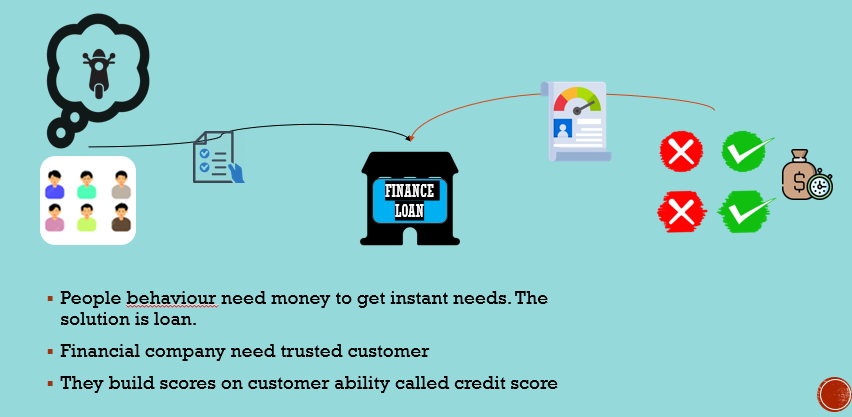

PURPOSE = To predict CREDIT SCORE as integer (350-850), berdasarkan data pemohon kredit potensial. yang berarti semakin tinggi skor pemohon dapat terpercaya diberikan pinjaman kredit untuk motor di india.

Value = meminimalisir kerugian akibat peminjam yang tidak membayar atau telat membayar
matrix = rmse dan mse 

example :

1 lakh = 100.000 rupee
ir = interest rate/suku bunga

range two wheeler loan 1-50 lakh:

8-12 % = loan with low interest rate, 50 lakh , ir 8% = 400.000, if in a year  
base 416.666 rupee/month + ir 33.333 rupee/month = 450.000/5000.000 = 9 %  minimize loss for the first month onward

12-15 % = loan with normal interest rate, 50 lakh , ir 12% = 600.000, if in a year  
base 416.666 rupee/month + ir 50.000 rupee/month = 466.666/5000.000 = 9,3 %  minimize loss for the first month onward

15-20 % = loan with high interest rate, 50 lakh , ir 15% = 750.000, if in a year  
base 416.666 rupee/month + ir 62.500 rupee/month = 479.166/5000.000 = 9,5 % minimize loss for the first month onwards

20-25 % = no loan or high interest rate if do loan, 50 lakh / 5.000.000 rupee,ir 20% =  1000.000, if in a year 
base 416.666 rupee/month + ir 83.333 rupee/month = 500.000/ 5000.000 = 10 % we can minimize loss up to 10 % for the first month onwards.

for credit score below 300 (base on fico credit score), we can reject loan submission and save 100 % / 50 lakh for the highest loan value

### cibil score (india) source IIFL finance.com

Excellent Credit Score - Around 750 and above
These Individuals are likely to have a high likelihood of loan approval and can access loans and credit at favourable terms, including lower interest rates.

Good Credit Score - In the range of 700 to 749
This scoring range also signifies a strong credit profile, and individuals within this range are generally considered reliable borrowers by lenders.

Fair Credit Score - Ranges from 650 to 699
Individuals with fair credit scores can have access to credit, but they might face slightly higher interest rates or more stringent lending conditions than those with higher scores.

Poor Credit Score - Below 650
They may face challenges in obtaining credit or loans as lenders may be more cautious due to the perceived higher credit risk.


### Fico credit score (US) mybanktracker.com 

300-580	Very Bad:	
Extremely difficult to obtain traditional loans and line of credit. Advised to use secured credit cards and loans to help rebuild credit.

580-669	Bad:
May be able to qualify for some loans and lines of credit, but the interest rates are likely to be high.

670-739	Average/Fair:
Eligible for many traditional loans, but the interest rates and terms may not be the best.

740-799	Good:
Valuable benefits come in the form of loans and lines of credit with comprehensive perks and low interest rates.

800-850	Excellent:
Qualify easily for most loans and lines of credit with low interest rates and favorable terms.

In [3]:
#read data

df = pd.read_csv('C:/Users/hp/Downloads/NEW PROJECT/credit_data.csv')
df.head(3)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

### DICTIONARY

Age:
Type: Integer\
Description: Represents the age of the applicant. Indicates the applicant's maturity level.\
Range: 18 to 70

Gender:
Type: Categorical\
Description: Gender of the applicant.\
Categories: Male, Female, Other

Income:
Type: Integer\
Description: The applicant's income, which is critical in assessing their ability to repay the loan.\
Range: Multiples of 1000's

Credit Score:
Type: Integer\
Description: A score quantifying the applicant's creditworthiness based on their credit history.\
Range: 300 to 850

Credit History Length:
Type: Integer\
Description: Represents the number of months since the applicant's first credit line. Indicates the applicant's experience with credit management.\
Units: Months

Number of Existing Loans:
Type: Integer\
Description: The number of loans the applicant currently has.\
Range: 0 to 10

Loan Amount:
Type: Integer\
Description: The amount of money the applicant is requesting.\
Range: 0 to 150,000

Loan Tenure:
Type: Integer\
Description: The number of months the applicant wants to repay the loan over.\
Units: Months

Existing Customer:
Type: Categorical\
Description: Whether the applicant is an existing customer of the finance company.\
Categories: Yes, No

State:
Type: Categorical\
Description: The state in India where the applicant resides.\
Categories: Maharashtra, Delhi, Karnataka, Tamil Nadu, West Bengal, Uttar Pradesh, Gujarat, Rajasthan, Kerala, Telangana, etc.

City:
Type: Categorical\
Description: The city or village in India where the applicant resides.\
Categories: Mumbai, Pune, New Delhi, Bengaluru, Chennai, Kolkata, Ahmedabad, Jaipur, Kochi, Hyderabad, and various villages.

LTV Ratio:
Type: Float\
Description: The loan-to-value ratio, represents the ratio of the loan amount to the appraised value of the asset (typically a house). Higher LTVs can indicate higher risk.\
Range: 40% to 95%

Employment Profile:
Type: Categorical\
Description: General employment category of the applicant.\
Categories: Salaried, Self-Employed, Freelancer, Unemployed, Student

Occupation:
Type: Categorical\
Description: Specific occupation or job title of the applicant.\
Categories: Software Engineer, Doctor, Teacher, Business Owner, Writer, etc.

Profile Score:
Type: Integer\
Description: A score ranging from 0 to 100 represents the overall profile of the applicant based on the actual loan repayment data. Higher values indicate better profiles.\
Range: 0 to 100

Property Value:
type : float\
Description : Value the reason customer want to loan (two wheel's value)

### DATA PREPARATION

##### add feature

In [4]:
#add property values feature

df['Property Value'] = round(df['Loan Amount'] / (df['LTV Ratio'] / 100),2)

##### duplicated

In [4]:
#duplicated handling

df.duplicated(subset=list(df.columns)).sum()
# ada banyak sekali record double

100814

In [7]:
#value check
df[df.duplicated(subset=list(df.columns),keep=False)].sort_values(by= list(df.columns)).head(3)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,Property Value
22723,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer,38558.95
176804,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer,38558.95
137592,18,Female,9000,328,235,0,44422,112,No,West Bengal,Kolkata,84.429872,Salaried,57,Doctor,52614.08


In [5]:
#drop duplicated row
df = df.drop_duplicates(subset=list(df.columns))

#### Missing value

In [9]:
#check missing value
df.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  11690
Property Value                  0
dtype: int64

In [9]:
11690/ len(df)

# there is 6 % missing value is occupation columns

0.06529194267266898

In [10]:
ds['Employment Profile'].unique()

#yang missing value merupakan yang tidak bekerja

array(['Unemployed'], dtype=object)

In [10]:
df[df['Employment Profile'] == 'Unemployed'].head(5)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
25,61,Female,41000,307,104,0,23296,99,No,Rajasthan,Udaipur,58.686622,Unemployed,23,NaN
28,52,Female,87000,697,26,7,141231,70,Yes,Delhi,New Delhi,94.616809,Unemployed,58,NaN
31,57,Female,130000,850,600,10,56891,195,Yes,Telangana,Hyderabad,40.481983,Unemployed,96,NaN
33,53,Male,33000,428,576,2,99179,56,No,Delhi,New Delhi,53.836170,Unemployed,62,NaN
41,18,Other,16000,329,436,0,12592,119,No,Telangana,Hyderabad,94.802565,Unemployed,17,NaN


In [6]:
#change missing value
df['Occupation'] = np.where(df['Occupation'].isnull(), 'None',df['Occupation'])

In [12]:
#check target value
print('credit score:','\n','min',df['Credit Score'].min(),'\n','max:',df['Credit Score'].max())

credit score: 
 min 300 
 max: 850


<AxesSubplot:>

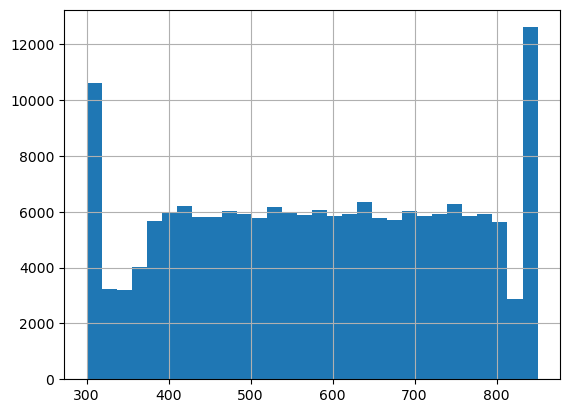

In [13]:
df['Credit Score'].hist(bins=30)
# i think not bad, dan ada fokus bahwa banyak yang 300 dan diatas 800 credit scorenya

In [7]:
# split feature 
numeric,category = group_feature(df)

In [11]:
#numeric feature
df[numeric].describe()

,Age,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,LTV Ratio,Profile Score,Property Value
count,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000,179042.000000
mean,43.990516,76437.483942,583.097977,308.016125,4.704645,105792.567833,133.325287,71.630713,77.377772,157903.527482
std,15.309904,42852.725718,163.079589,175.039559,2.980465,40436.205650,96.008844,16.867650,24.496880,76769.755374
min,18.000000,9000.000000,300.000000,6.000000,0.000000,5294.000000,12.000000,40.000000,0.000000,5983.160000
25%,31.000000,42000.000000,447.000000,156.000000,2.000000,72220.000000,62.000000,58.079412,61.000000,100145.060000
50%,44.000000,68000.000000,584.000000,307.000000,5.000000,111284.000000,100.000000,72.153227,89.000000,155737.300000
75%,57.000000,104000.000000,722.000000,460.000000,7.000000,150000.000000,201.000000,86.212457,98.000000,202860.160000
max,70.000000,209000.000000,850.000000,611.000000,10.000000,150000.000000,359.000000,95.000000,100.000000,375000.000000


In [656]:
df['Loan Tenure'].describe()

count    179042.000000
mean        133.325287
std          96.008844
min          12.000000
25%          62.000000
50%         100.000000
75%         201.000000
max         359.000000
Name: Loan Tenure, dtype: float64

In [23]:
# there is value need to be focused on two wheeler loan tenure that more than  max up to 359 months (30 years)in concept
# for two wheeler loan in india its really weird.

#checked from bankbazaar.com platform (india) for two wheeler loan tenure
# from official national and private bank there no bank provide loan tenure more than 7 years
# and emi calculator there is only up to 84 month 

In [24]:
df[df['Loan Tenure'] > 84].describe()

,Age,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,LTV Ratio,Profile Score,Property Value
count,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000,107973.000000
mean,44.591268,79450.538561,652.127652,308.124040,5.958351,106916.999555,187.929973,68.931991,85.258305,167054.558875
std,15.285004,43710.806663,149.658998,174.936742,2.760369,40141.179414,86.438198,17.295207,20.649741,81398.465636
min,18.000000,9000.000000,300.000000,6.000000,0.000000,5294.000000,85.000000,40.000000,0.000000,5983.160000
25%,31.000000,44000.000000,566.000000,157.000000,4.000000,73671.000000,108.000000,55.118095,79.000000,105971.700000
50%,45.000000,71000.000000,679.000000,307.000000,6.000000,113090.000000,167.000000,69.156336,94.000000,157894.740000
75%,58.000000,109000.000000,769.000000,460.000000,8.000000,150000.000000,263.000000,83.204073,100.000000,214604.960000
max,70.000000,209000.000000,850.000000,611.000000,10.000000,150000.000000,359.000000,95.000000,100.000000,375000.000000


In [663]:
df[df['Loan Tenure'] > 84].shape[0]/len(df)

0.6030596172965003

<AxesSubplot:xlabel='Loan Tenure', ylabel='Credit Score'>

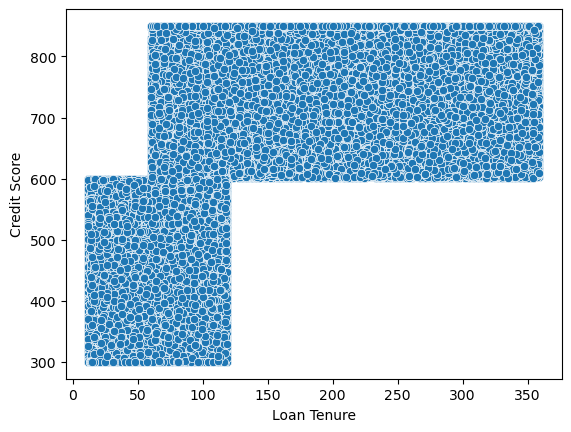

In [25]:
sns.scatterplot(x=df['Loan Tenure'],y=df['Credit Score'])

<AxesSubplot:xlabel='Loan Tenure', ylabel='Credit Score'>

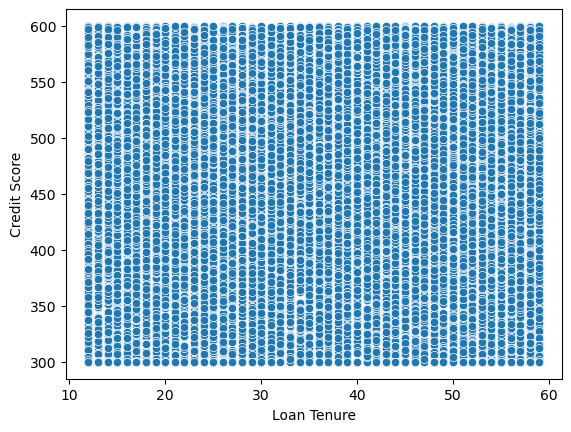

In [70]:
ds = df[df['Loan Tenure'] < 60 ]
sns.scatterplot(x=ds['Loan Tenure'],y=ds['Credit Score'])

In [ ]:
# we can feature engineering it to do discrete into three values

In [664]:
#skewness check
df[numeric].skew()

Age                        -0.001824
Income                      0.710915
Credit Score               -0.040378
Credit History Length       0.009615
Number of Existing Loans    0.051856
Loan Amount                -0.439780
Loan Tenure                 0.843219
LTV Ratio                  -0.180956
Profile Score              -1.018225
Property Value              0.584850
dtype: float64

In [ ]:
# still normal based on border skew 2.0 and -2.0

In [13]:
#category feature
df[category].describe()

,Gender,Existing Customer,State,City,Employment Profile,Occupation
count,179042,179042,179042,179042,179042,179042
unique,3,2,10,23,5,15
top,Female,No,West Bengal,Kolkata,Salaried,Banker
freq,82955,111244,18031,15352,87138,17788


In [ ]:
# gender ada other namun kita abaikan dulu dalam model
#existing customer binary

In [14]:
# check value category
for i in category:
    print(df[i].value_counts())

Female    82955
Male      82746
Other     13341
Name: Gender, dtype: int64
No     111244
Yes     67798
Name: Existing Customer, dtype: int64
West Bengal      18031
Karnataka        18003
Telangana        17959
Gujarat          17954
Delhi            17950
Maharashtra      17929
Kerala           17903
Uttar Pradesh    17846
Tamil Nadu       17813
Rajasthan        17654
Name: State, dtype: int64
Kolkata               15352
New Delhi             15308
Hyderabad             15152
Mysuru                 7794
Kanpur                 7770
Surat                  7695
Udaipur                7680
Thiruvananthapuram     7641
Ahmedabad              7569
Chennai                7550
Coimbatore             7533
Bengaluru              7510
Kochi                  7504
Lucknow                7501
Jaipur                 7334
Manjari                5469
Dhulagori              5444
Bishanpura             5378
Channarayapatna        5316
Nellikuppam            5287
Mumbai                 5185
Nagpur         

In [9]:
#outlier check
# d_skew = [i for i in numeric]
# outlier = check_outliers(d_skew,df)

# not use this because the value is too little and reasonable for model variation

### DATA VISUALIZATION

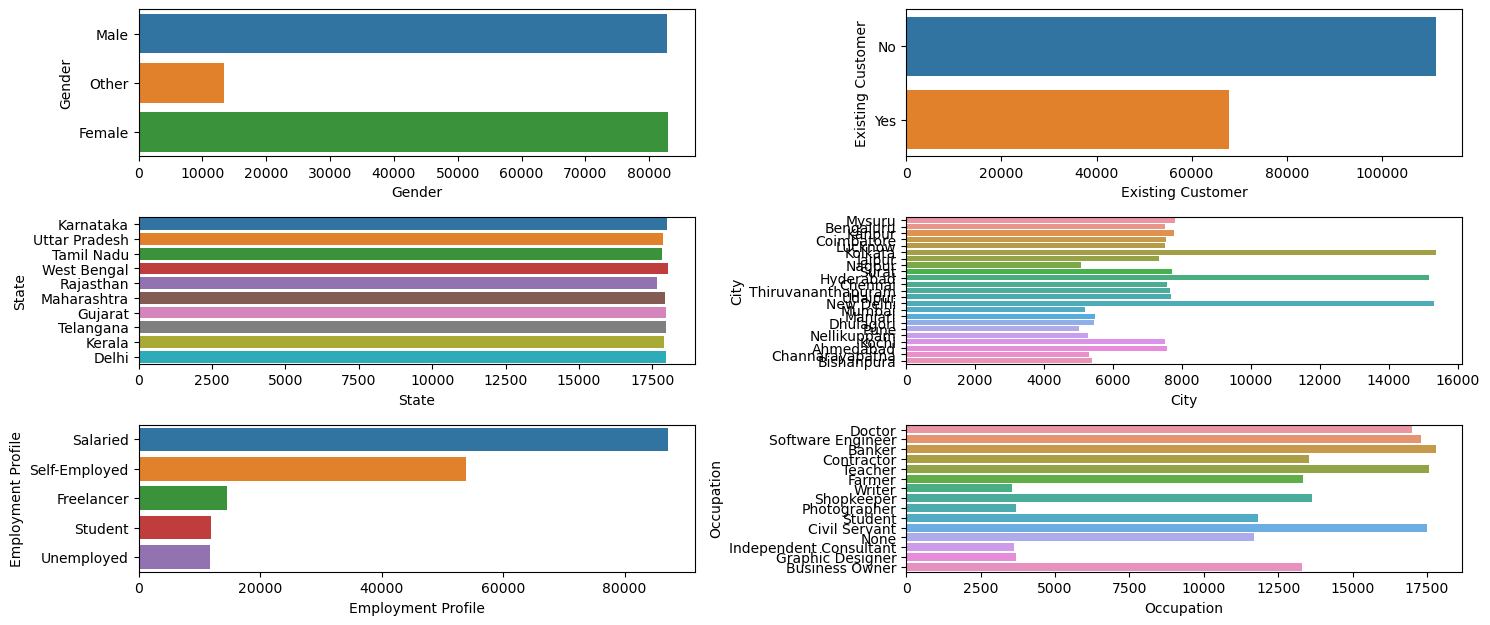

In [15]:
#category UNIVARIATE

plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(4,len(category)//3,index)
    sns.countplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

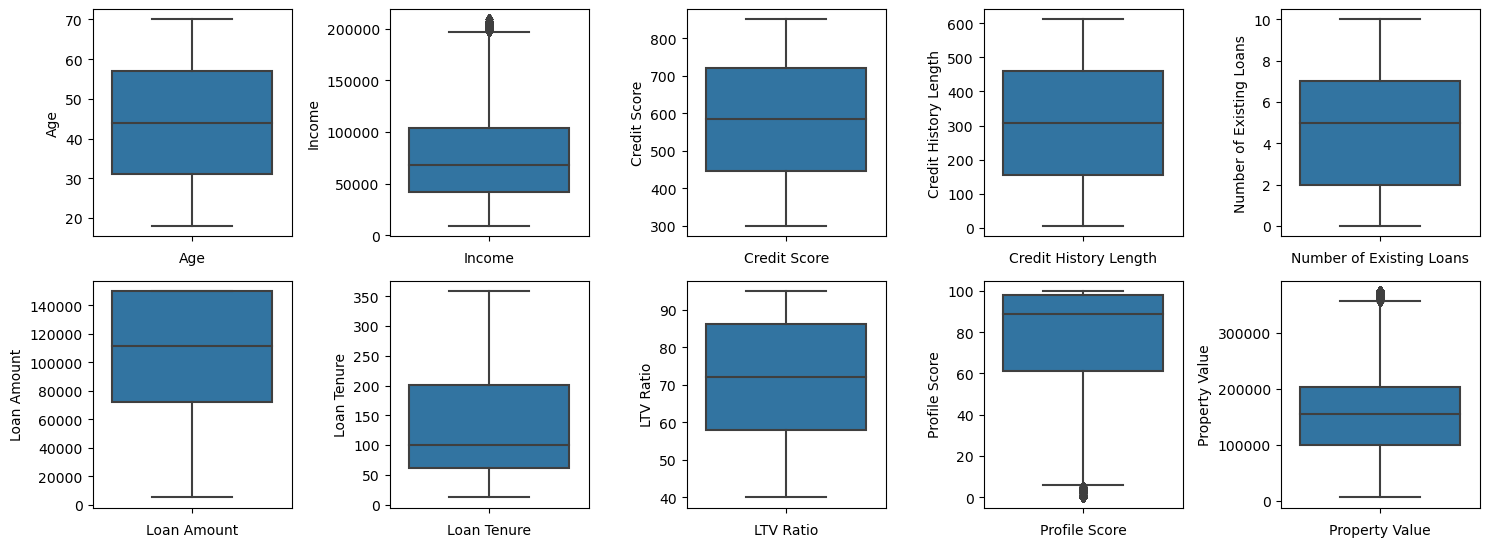

In [16]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(3,len(numeric)//2,index)
    sns.boxplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [21]:
# down = values[0][1] 
# s = df[df['Profile Score'].isin(down)]
# plt.figure(figsize=(3,4))
# index = 1
# sns.scatterplot(x=s['Profile Score'],y= s['Profile Score'])

In [8]:
# df = df[~(df['Profile Score'].isin(down))]

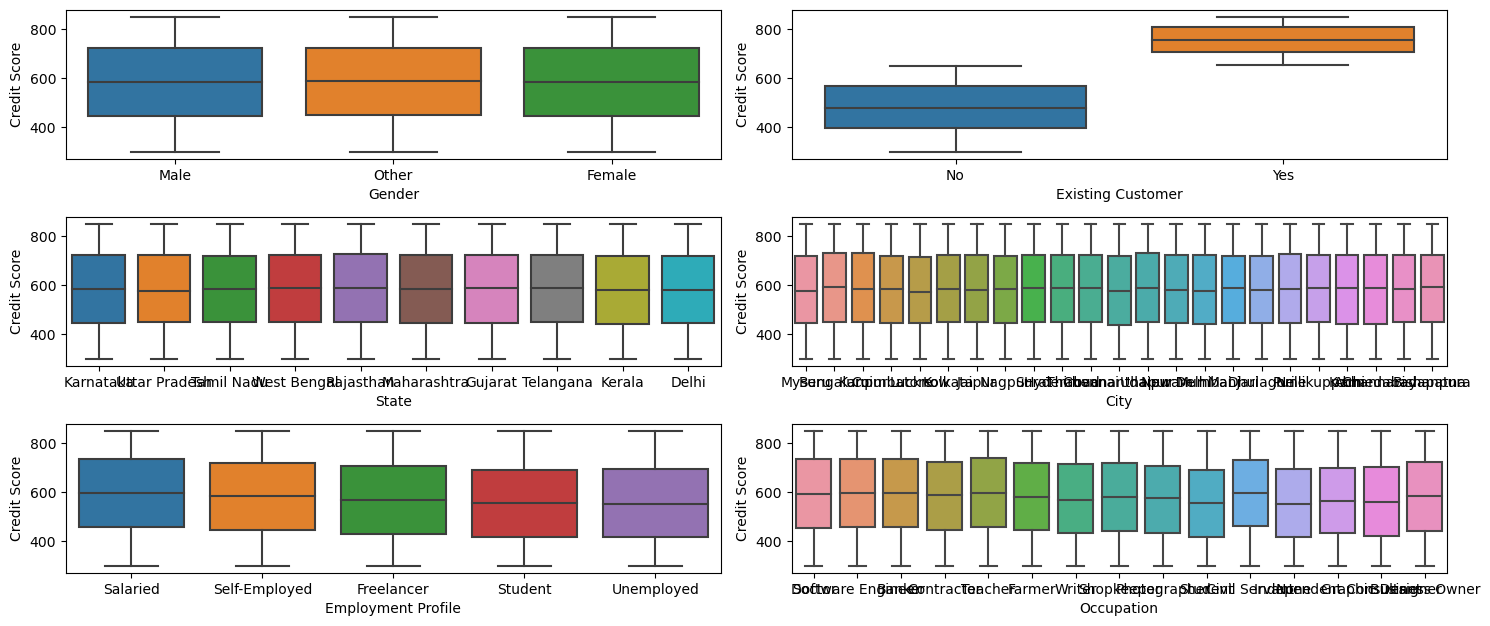

In [17]:
plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(4,len(category)//3,index)
    sns.boxplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
#existing customer that value is yes have more credit score than value no 
#other else there is no clear insight here cause there is no difference in distribution beetween each values in each feature 
# so, no use for models

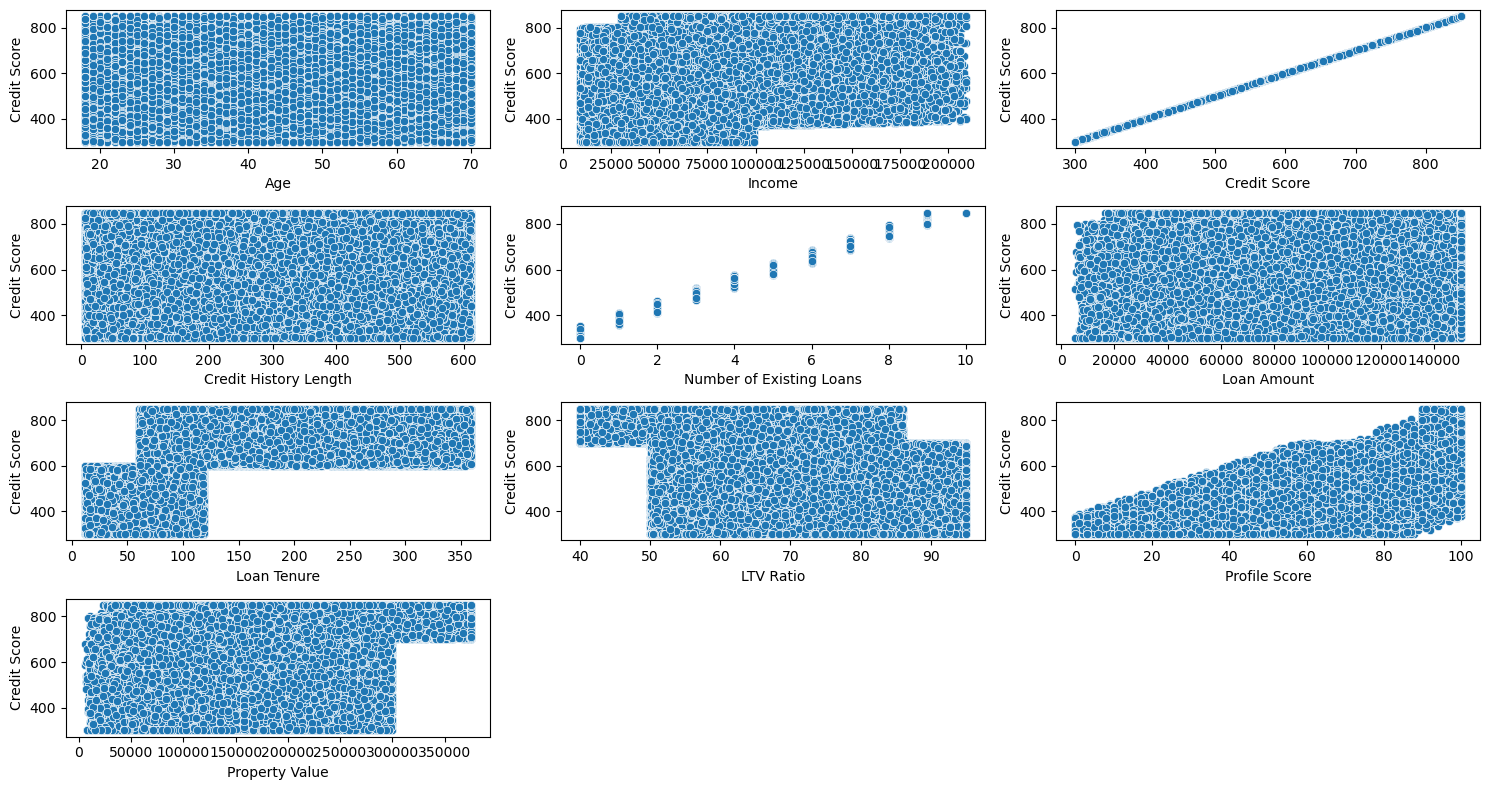

In [18]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(4,len(numeric)//3,index)
    sns.scatterplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
# more high  profile score more high credit score, more good profile score that customer is more trusted. but the feauture
# cant be use because there is no information where to get the value, so for the demo is no work. (DROPPED COLUMN)

#more high number of existing loans more high credit score (range 10)
#most of loan tenure bellow 50 have credit score bellow 600  (or range of repayment 4 years)
#ltv ratio bellow 50% have credit score more than 700

In [24]:
df[df['LTV Ratio'] <= 50]['Credit Score'].min()

701

In [90]:
df[df['Property Value'] <25300]['Credit Score'].max()

810

In [99]:
df[df['Property Value'] > 300000]['Credit Score'].min()

701

### EDA VISUAL

In [690]:
ec = ['LTV Ratio','Number of Existing Loans']

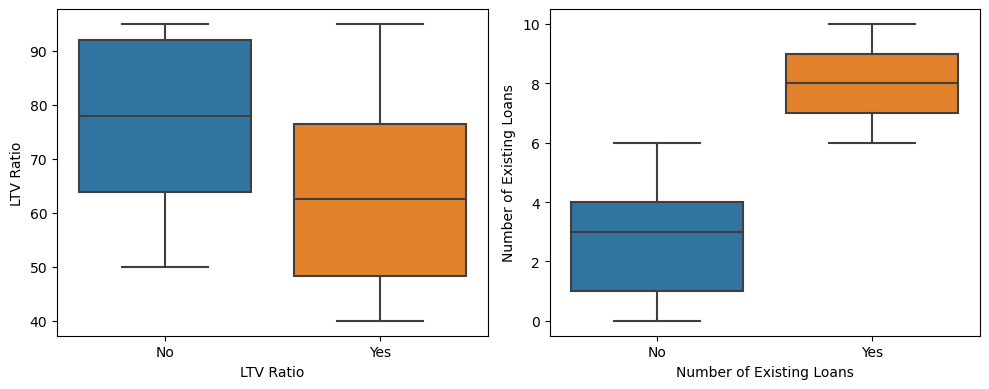

In [693]:
plt.figure(figsize=(10,4))
index = 1

for i in ec:
    plt.subplot(1,len(ec),index)
    sns.boxplot(x=df['Existing Customer'],y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

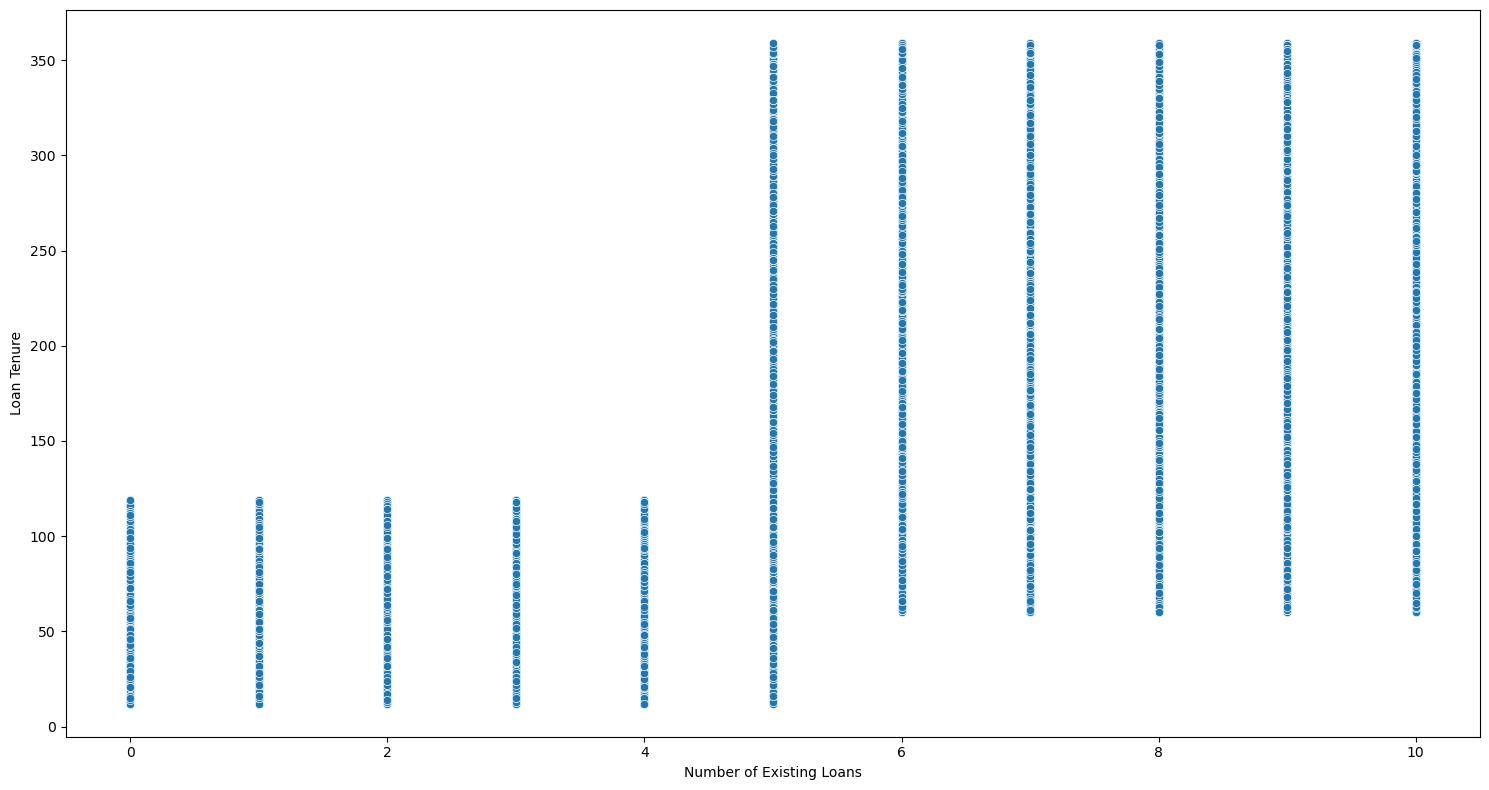

In [706]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=df['Number of Existing Loans'],y=df['Loan Tenure'])
plt.xlabel('Number of Existing Loans')
plt.tight_layout()

### SPLIT DATA

In [8]:
# train- test split
train,test = train_test_split(df,test_size= 0.20,random_state=1)

In [9]:
# x & y split
X_train = train[[i for i in train.columns if i != 'Credit Score']]
y_train = train['Credit Score']
X_test = test[[i for i in df.columns if i != 'Credit Score']]
y_test = test['Credit Score']

In [10]:
X_train.head(5)

,Age,Gender,Income,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,Property Value
89006,50,Male,100000,573,4,117240,30,No,Delhi,New Delhi,95.000000,Salaried,85,Software Engineer,123410.53
174447,21,Female,26000,14,7,40924,151,Yes,West Bengal,Bishanpura,79.018278,Self-Employed,100,Farmer,51790.55
205816,28,Female,77000,581,2,150000,73,No,Kerala,Nellikuppam,51.353710,Self-Employed,85,Contractor,292091.85
148147,41,Male,71000,418,3,126397,109,No,Gujarat,Ahmedabad,59.029879,Salaried,99,Teacher,214123.76
128586,48,Male,123000,76,9,107252,348,Yes,Uttar Pradesh,Lucknow,58.460910,Salaried,100,Software Engineer,183459.34


In [11]:
X_test.head(5)

,Age,Gender,Income,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,Property Value
80435,24,Female,36000,38,8,119951,239,Yes,Maharashtra,Mumbai,55.517231,Student,96,Student,216060.85
33228,66,Female,147000,218,2,150000,44,No,West Bengal,Kolkata,78.884834,Salaried,51,Software Engineer,190150.62
264739,34,Female,91000,599,3,135763,24,No,Gujarat,Ahmedabad,58.228542,Salaried,92,Software Engineer,233155.42
128294,68,Female,175000,232,3,150000,90,No,Delhi,New Delhi,86.010721,Salaried,48,Software Engineer,174396.86
23877,63,Female,45000,65,6,106203,149,Yes,Gujarat,Ahmedabad,62.097551,Self-Employed,95,Business Owner,171026.07


In [12]:
y_train.head(3)

89006     569
174447    728
205816    413
Name: Credit Score, dtype: int64

In [13]:
y_test.head(3)

80435     751
33228     450
264739    511
Name: Credit Score, dtype: int64

### FEATURE ENGINEERING

In [380]:
# def employ(dataframe):    
#     condition = [
#         dataframe['Employment Profile'] == 'Salaried',
#         dataframe['Employment Profile'] == 'Self-Employed',
#         dataframe['Employment Profile'] == 'Freelancer',
#         dataframe['Employment Profile'] == 'Student', 
#         dataframe['Employment Profile'] == 'Unemployed', 
#     ]

#     choice = ['employee','non_employee','non_employee','not_personal_income','not_personal_income']
#     dataframe['Employment Profile'] = np.select(condition,choice,default=dataframe['Employment Profile'])
#     return dataframe

# X_train = employ(X_train)
# X_test = employ(X_test)

In [58]:
# dummies_occupation = pd.get_dummies(df2['Occupation'],dtype=int)
# df2 = pd.concat([df2,dummies_occupation],axis=1)

In [361]:
# # Employment profile

# dummies_employ = pd.get_dummies(X_train['Employment Profile'],dtype=int)
# X_train = pd.concat([X_train,dummies_employ],axis=1)

# dummies_employ_test = pd.get_dummies(X_test['Employment Profile'],dtype=int)
# X_test = pd.concat([X_test,dummies_employ_test],axis=1)

In [14]:
encoder = LabelEncoder()
X_train['Employment Profile'] = encoder.fit_transform(X_train['Employment Profile'])
X_test['Employment Profile'] = encoder.transform(X_test['Employment Profile'])

C:\Users\hp\AppData\Local\Temp\ipykernel_9692\2829899250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Employment Profile'] = encoder.fit_transform(X_train['Employment Profile'])
C:\Users\hp\AppData\Local\Temp\ipykernel_9692\2829899250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Employment Profile'] = encoder.transform(X_test['Employment Profile'])


In [65]:
# def pv(dataframe):
#     condition = [
#         dataframe['Property Value'] <= 25500,
#         (dataframe['Property Value']> 25500) & (dataframe['Property Value'] <=300000),
#         (dataframe['Property Value'] > 300000),
#     ]
#     choice = ['Below25500','25500to300000','Above300000']
#     dataframe['Property Value'] = np.select(condition,choice,dataframe['Property Value'])
#     return dataframe

# df2 = pv(df2)
# X_test = pv(X_test)

In [95]:
# dummies_pv = pd.get_dummies(X_train['Property Value'],dtype= int)
# X_train = pd.concat([X_train,dummies_pv], axis=1)
# dummies_pvtest = pd.get_dummies(X_test['Property Value'],dtype= int)
# X_test = pd.concat([X_test,dummies_pvtest], axis=1)

In [ ]:
# DRY --> Dont Repeat Yourself

### FEATURING

In [15]:
df2 = pd.concat([X_train,y_train],axis=1)

In [58]:
df2.head()

,Age,Gender,Income,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation,Property Value,Credit Score
89006,50,Male,100000,573,4,117240,30,No,Delhi,New Delhi,95.000000,1,85,Software Engineer,123410.53,569
174447,21,Female,26000,14,7,40924,151,Yes,West Bengal,Bishanpura,79.018278,2,100,Farmer,51790.55,728
205816,28,Female,77000,581,2,150000,73,No,Kerala,Nellikuppam,51.353710,2,85,Contractor,292091.85,413
148147,41,Male,71000,418,3,126397,109,No,Gujarat,Ahmedabad,59.029879,1,99,Teacher,214123.76,505
128586,48,Male,123000,76,9,107252,348,Yes,Uttar Pradesh,Lucknow,58.460910,1,100,Software Engineer,183459.34,833


#### binary

In [16]:
# existing customer
df2['Existing Customer'] = np.where(df2['Existing Customer'] == 'Yes',15, 30)
X_test['Existing Customer'] = np.where(X_test['Existing Customer'] == 'Yes',15,30)


C:\Users\hp\AppData\Local\Temp\ipykernel_9692\2873123828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Existing Customer'] = np.where(X_test['Existing Customer'] == 'Yes',15,30)


In [17]:
# loan tenure
df2['Loan Tenure'] = np.where(df2['Loan Tenure'] <= 60, 5, 10)
X_test['Loan Tenure'] = np.where(X_test['Loan Tenure'] <= 60, 5, 10)

C:\Users\hp\AppData\Local\Temp\ipykernel_9692\919124505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Loan Tenure'] = np.where(X_test['Loan Tenure'] <= 60, 5, 10)


In [32]:
# #gender 
# encoder = LabelEncoder()
# df2['Gender'] = encoder.fit_transform(df2['Gender'])
# X_test['Gender'] = encoder.transform(X_test['Gender'])
# df2['Gender'] = np.where(df2['Gender'] == 'Male', 1,0)
# X_test['Gender'] = np.where(X_test['Gender'] == 'Male', 1,0)

#### else

In [18]:
# drop feature that hasn't functional and multicolinearity
df2 = df2.drop(['Credit History Length','Gender','Profile Score','Loan Amount'],axis=1)#,'Employment Profile','Age','Existing Customer'],axis=1)
X_test = X_test.drop(['Credit History Length','Gender','Profile Score','Loan Amount'],axis=1)#,'Employment Profile','Profile Score','Existing Customer'],axis=1)

In [389]:
# # #multicolinearity age
# #range age 18-70 , make 4 class

# def choice(data):
#     condition = [
#         data['Age'] <= 31,
#         (data['Age'] > 31) & (data['Age'] <=44),
#         (data['Age'] > 44) & (data['Age'] <=57),
#         (data['Age'] > 57),
#     ]
#     choice = ['<=31','32-44','45-57','>57']
#     data['Age'] = np.select(condition,choice,data['Age'])
#     return data

In [19]:
#multikolinearity age pangkat 3/2

df2['Age'] = df2['Age'] ** 3/2
X_test['Age'] = X_test['Age'] ** 3/2

In [388]:
# df2= choice(df2)
# X_test = choice(X_test)

In [368]:
# encoder = LabelEncoder()
# df2['Age'] = encoder.fit_transform(df2['Age'])
# X_test['Age'] = encoder.transform(X_test['Age'])

In [24]:
# X_test['Age'] = np.select(condition,choice,X_test['Age'])

In [559]:
df2['Age'].unique()

array([ 62500. ,   4630.5,  10976. ,  34460.5,  55296. ,   5324. ,
       137312.5, 119164. , 102689.5,  29659.5,  87808. , 143748. ,
        27436. ,  70304. , 157216. , 108000. ,  19652. ,  97556. ,
        48668. ,   2916. , 150381.5,  32000. ,   4000. ,  92596.5,
        39753.5,  83187.5,  13500. ,  25326.5,  45562.5,  42592. ,
        51911.5,   8788. , 131072. ,   7812.5,  21437.5,   6083.5,
         6912. ,  14895.5,  12194.5,  74438.5,  37044. , 164254.5,
         3429.5, 171500. ,  58824.5, 113490.5, 125023.5,  16384. ,
        66325.5,   9841.5,  17968.5,  23328. ,  78732. ])

#### check correl and multicolinearity

<AxesSubplot:>

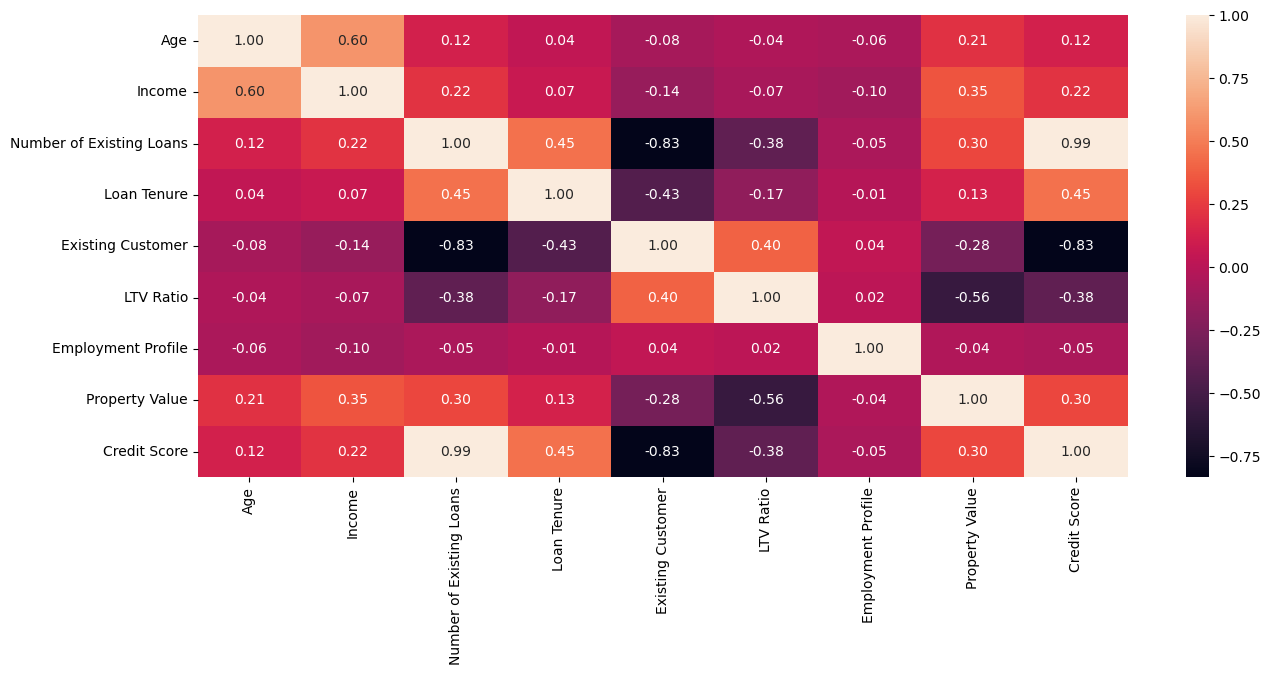

In [20]:
plt.figure(figsize=[15,6])
ds = df2.select_dtypes(include=[float,int])
corr = ds.corr()
sns.heatmap(corr,annot=True,fmt='.2f')

In [21]:
# not continous
nc = ['Existing Customer','Credit Score','Gender','Loan Tenure'] #+ list(dummies_employ)#+ list(dummies_pv) 

In [22]:
# VIF ANALYSYS
X_matriks = ds[[i for i in ds.columns  if i not in nc]]
VIF_table(X_matriks)

,col,val
0,Age,3.679751
1,Income,7.409662
2,Number of Existing Loans,3.640484
3,LTV Ratio,5.573720
4,Employment Profile,3.405695
5,Property Value,5.407565


### save cleaned data

In [23]:
# #save cleaned data
# ds.to_csv('cleaned_dataset.csv')

#### Premodel

In [24]:
# train data
col = list(df2.select_dtypes(include=[int,float]))
X_train = df2[col[0:-1]]
y_train = df2[col[-1]]
X_test = X_test[[i for i in col if i != 'Credit Score']]

In [510]:
X_train.head(1)

,Age,Income,Number of Existing Loans,Loan Tenure,Existing Customer,LTV Ratio,Employment Profile,Property Value
89006,62500.0,100000,4,5,30,95.0,1,123410.53


In [512]:
X_train['Employment Profile'].unique()

array([1, 2, 4, 3, 0])

In [550]:
X_test['Age'].unique()

array([nan], dtype=float32)

In [511]:
X_test.head(1)

,Age,Income,Number of Existing Loans,Loan Tenure,Existing Customer,LTV Ratio,Employment Profile,Property Value
80435,NaN,36000,8,10,15,55.517231,3,216060.85


In [645]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143233 entries, 89006 to 166442
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       143233 non-null  float64
 1   Income                    143233 non-null  int64  
 2   Number of Existing Loans  143233 non-null  int64  
 3   Loan Tenure               143233 non-null  int32  
 4   Existing Customer         143233 non-null  int32  
 5   LTV Ratio                 143233 non-null  float64
 6   Employment Profile        143233 non-null  int32  
 7   Property Value            143233 non-null  float64
dtypes: float64(3), int32(3), int64(2)
memory usage: 8.2 MB


In [646]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35809 entries, 80435 to 117374
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       35809 non-null  float64
 1   Income                    35809 non-null  int64  
 2   Number of Existing Loans  35809 non-null  int64  
 3   Loan Tenure               35809 non-null  int32  
 4   Existing Customer         35809 non-null  int32  
 5   LTV Ratio                 35809 non-null  float64
 6   Employment Profile        35809 non-null  int32  
 7   Property Value            35809 non-null  float64
dtypes: float64(3), int32(3), int64(2)
memory usage: 2.0 MB


In [613]:
# X_coba = X_train[[i for i in X_train if i != 'Number of Existing Loans']]
# X_test_coba = X_test[[i for i in X_train if i != 'Number of Existing Loans']]
# X_coba

#### FEATURE SCALING

In [61]:
# X_train.columns

In [35]:
# sc = StandardScaler()

# col = [i for i in X_train.columns if i not in nc]
# cc = [ i for i in nc if i not in ['Credit Score','Gender']]     
# scaled = sc.fit_transform(X_train[col])
# scaled = pd.DataFrame(scaled)
# scaled.columns = col
# X_train_scaled = pd.concat([scaled,X_train[cc].reset_index(drop=True)],axis=1)

# test_scaled = sc.transform(X_test[col])
# test_scaled = pd.DataFrame(test_scaled)
# test_scaled.columns = col
# X_test_scaled = pd.concat([test_scaled,X_test[cc].reset_index(drop=True)],axis=1)

In [295]:
# # save scaling 
# with open('standarscaler.pkl','wb')as file:
#     pickle.dump(sc,file)

In [60]:
# X_train_scaled.columns

### MODELING

In [635]:
model = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'XGB': XGBRegressor(),
    'Lasso': Lasso(),
    'Lgbm' : LGBMRegressor(),
    'rf': RandomForestRegressor()
}

param = {
    'lr': {},
    'XGB':{
        'random_state': [1]
    },
    'ridge':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'Lasso':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'SGD':{
        'random_state': [1],
        'max_iter': [1000]
    },
     'Lgbm':{
        'random_state': [1]
    },
     'rf':{
        'random_state': [1],
         'max_depth':[30]
    },
}

In [637]:
# import time
# from rich.progress import track

# start_time = time.time()
# track()

models = {}
test_predict = {}
for i in model.keys():
    gridsearch = GridSearchCV(estimator=model[i],param_grid= param[i],scoring='neg_mean_squared_error',cv=5)
    gridsearch.fit(X_train,y_train)
    y_pred_train = gridsearch.predict(X_train)
    models[i] = pd.DataFrame(gridsearch.cv_results_)
    models[i]['RMSE'] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    models[i]['R_square'] = r2_score(y_train, y_pred_train)
    y_pred = gridsearch.predict(X_test)
    
    test_predict[i] = {'MSE':np.mean((y_pred - y_test) ** 2), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),'R_Square':r2_score(y_test, y_pred)}

    
# end_time = time.time()
# print(f'Total Waktu : {(end_time - start_time)} detik')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 114586, number of used features: 8
[LightGBM] [Info] Start training from score 583.075315
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 114586, number of used features: 8
[LightGBM] [Info] Start training from score 582.950832
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

In [638]:
# the results
results = pd.concat(models.values(), ignore_index=True)
results['model'] = [i for i in model]
results
retain_cols = ['model','params','mean_test_score','RMSE','R_square']
results[retain_cols]
results[retain_cols].sort_values('RMSE')

,model,params,mean_test_score,RMSE,R_square
5,rf,"{'max_depth': 30, 'random_state': 1}",-124.553459,5.157267,0.999000
2,XGB,{'random_state': 1},-203.581927,13.786937,0.992852
4,Lgbm,{'random_state': 1},-208.464913,14.291214,0.992319
0,lr,{},-284.169419,16.855650,0.989316
1,ridge,"{'max_iter': 1000, 'random_state': 1}",-284.169419,16.855650,0.989316
3,Lasso,"{'max_iter': 1000, 'random_state': 1}",-284.494062,16.865740,0.989303


In [ ]:
# baseline

# model	params	mean_test_score	RMSE	R_square
# 5	rf	{'random_state': 1}	-124.214499	3.957030	0.999411
# 2	XGB	{'random_state': 1}	-204.549891	13.846401	0.992790
# 4	Lgbm	{'random_state': 1}	-208.902416	14.313284	0.992296
# 0	lr	{}	-284.156996	16.855440	0.989316
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-284.156995	16.855440	0.989316
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-284.491244	16.865770	0.989303

#employment profile

# 	model	params	mean_test_score	RMSE	R_square
# 5	rf	{'random_state': 1}	-120.563758	3.759550	0.999468
# 2	XGB	{'random_state': 1}	-204.354060	13.863322	0.992773
# 4	Lgbm	{'random_state': 1}	-208.610962	14.303528	0.992306
# 0	lr	{}	-284.174733	16.854860	0.989317
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-284.174729	16.854860	0.989317
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-284.491244	16.865770	0.98930342

# age transformation 

# model	params	mean_test_score	RMSE	R_square
# 5	rf	{'random_state': 1}	-117.991474	3.604674	0.999511
# 2	XGB	{'random_state': 1}	-203.581927	13.786937	0.992852
# 4	Lgbm	{'random_state': 1}	-208.464913	14.291214	0.992319
# 0	lr	{}	-284.169419	16.855650	0.989316
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-284.169419	16.855650	0.989316
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-284.494062	16.865740	0.989303

#max depth
# model	params	mean_test_score	RMSE	R_square
# 5	rf	{'max_depth': 30, 'random_state': 1}	-124.553459	5.157267	0.999000
# 2	XGB	{'random_state': 1}	-203.581927	13.786937	0.992852
# 4	Lgbm	{'random_state': 1}	-208.464913	14.291214	0.992319
# 0	lr	{}	-284.169419	16.855650	0.989316
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-284.169419	16.855650	0.989316
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-284.494062	16.865740	0.989303

In [641]:
# test predict
pd.DataFrame(test_predict) 

,lr,ridge,XGB,Lasso,Lgbm,rf
MSE,283.919109,283.919061,203.052866,284.280858,208.851312,104.354887
RMSE,16.849899,16.849898,14.249662,16.860630,14.451689,10.215424
R_Square,0.989329,0.989329,0.992368,0.989316,0.992151,0.996078


In [37]:
# baseline

# lr	ridge	XGB	Lasso	Lgbm	rf
# MSE	283.919750	283.919703	204.009665	284.282790	209.115071	99.784639
# RMSE	16.849918	16.849917	14.283195	16.860688	14.460812	9.989226
# R_Square	0.989329	0.989329	0.992332	0.989315	0.992141	0.996250

#employment profile
# lr	ridge	XGB	Lasso	Lgbm	rf
# MSE	283.913708	283.913657	204.138857	284.282790	208.906603	95.723608
# RMSE	16.849739	16.849738	14.287717	16.860688	14.453602	9.783844
# R_Square	0.989329	0.989329	0.992328	0.989315	0.992148	0.996402

# age transformation

# lr	ridge	XGB	Lasso	Lgbm	rf
# MSE	283.919109	283.919061	203.052866	284.280858	208.851312	92.873654
# RMSE	16.849899	16.849898	14.249662	16.860630	14.451689	9.637098
# R_Square	0.989329	0.989329	0.992368	0.989316	0.992151	0.996509

#max depth

# lr	ridge	XGB	Lasso	Lgbm	rf
# MSE	283.919109	283.919061	203.052866	284.280858	208.851312	104.354887
# RMSE	16.849899	16.849898	14.249662	16.860630	14.451689	10.215424
# R_Square	0.989329	0.989329	0.992368	0.989316	0.992151	0.996078


### TUNNING

#### ensemble model

In [633]:
import time

start_time = time.time()

rf = RandomForestRegressor()
param = {
    'random_state':[1],
    'n_estimators':[100],
    'max_depth': [3,4,5,6,12,18,19,20,21,22,23,24,25,26,27,28,29,30],
    'min_samples_split': [2],
    
}

gridsearch = GridSearchCV(estimator=rf,param_grid= param,scoring='neg_mean_squared_error',cv=5)
gridsearch.fit(X_train,y_train)
cc = pd.DataFrame(gridsearch.cv_results_)

end_time = time.time()
print(f'Total Waktu : {(end_time - start_time)/60} menit')
cc

Total Waktu : 75.67138778765997 menit


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.880912,0.164726,0.190637,0.006251,3,2,100,1,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",-443.698102,-448.448661,-447.260864,-451.124323,-484.240241,-454.954438,14.836100,14
1,25.902091,0.138989,0.231256,0.022960,4,2,100,1,"{'max_depth': 4, 'min_samples_split': 2, 'n_es...",-224.287653,-223.407218,-223.523594,-222.909852,-225.660012,-223.957666,0.958770,13
2,30.461836,0.290883,0.278142,0.022964,5,2,100,1,"{'max_depth': 5, 'min_samples_split': 2, 'n_es...",-212.445756,-212.106375,-212.313233,-211.565160,-214.337016,-212.553508,0.940957,12
3,34.049400,0.170463,0.318771,0.018754,6,2,100,1,"{'max_depth': 6, 'min_samples_split': 2, 'n_es...",-210.512742,-210.110087,-210.540711,-209.698098,-212.505093,-210.673346,0.966131,11
4,53.216440,0.702214,0.562539,0.029648,12,2,100,1,"{'max_depth': 12, 'min_samples_split': 2, 'n_e...",-199.928645,-199.831732,-199.778389,-199.215476,-202.386091,-200.228067,1.107371,10
5,70.540224,1.289905,1.072115,0.029113,18,2,100,1,"{'max_depth': 18, 'min_samples_split': 2, 'n_e...",-169.268099,-168.785780,-169.816553,-168.099183,-172.717235,-169.737370,1.593440,9
6,72.917430,0.582774,1.190705,0.041223,19,2,100,1,"{'max_depth': 19, 'min_samples_split': 2, 'n_e...",-163.486561,-162.826052,-164.082128,-162.134885,-166.969467,-163.899819,1.667017,8
7,74.984039,0.491417,1.287584,0.052853,20,2,100,1,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",-157.742227,-157.039826,-158.467913,-156.564327,-161.227878,-158.208434,1.641368,7
8,77.171313,0.651863,1.440721,0.018222,21,2,100,1,"{'max_depth': 21, 'min_samples_split': 2, 'n_e...",-152.459342,-151.805699,-153.153747,-151.156661,-155.893887,-152.893867,1.640638,6
9,78.744112,0.460024,1.537602,0.035080,22,2,100,1,"{'max_depth': 22, 'min_samples_split': 2, 'n_e...",-147.556277,-146.785793,-148.355862,-146.192709,-150.937015,-147.965531,1.654342,5


In [569]:
cc[cc['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
152,131.457795,17.698324,2.695165,0.638269,25,2,100,1,"{'max_depth': 25, 'min_samples_split': 2, 'n_e...",-135.339365,-134.88698,-136.111664,-134.650228,-138.693066,-135.936261,1.465735,1


In [ ]:
# RF
# # criteria
# max depth = 25
# min_samples_split= 2
# n_estimators = 100 
# random_state =1 

In [ ]:
xgb = XGBRegressor()
param = {
    'random_state':[1],
    'max_depth': [18],
    'max_leaves':[2],
    
}

gridsearch = GridSearchCV(estimator=xgb,param_grid= param,scoring='neg_mean_squared_error',cv=5)
gridsearch.fit(X_train_scaled,y_train)
cc = pd.DataFrame(gridsearch.cv_results_)
cc

#### regularization

In [603]:
ridge = Ridge()
alphas = np.logspace(-3, 3, 30)
param = {
    'alpha':alphas
}

gridsearch = GridSearchCV(estimator=ridge,param_grid= param,scoring='neg_mean_squared_error',cv=5)
gridsearch.fit(X_train,y_train)
cc = pd.DataFrame(gridsearch.cv_results_)
cc.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069659,0.023985,0.009845,0.005783,0.001,{'alpha': 0.001},-285.289957,-281.787131,-281.954504,-283.8194,-287.996102,-284.169419,2.306633,17
1,0.050006,0.006248,0.012499,0.006249,0.00161,{'alpha': 0.0016102620275609393},-285.289957,-281.787131,-281.954504,-283.8194,-287.996102,-284.169419,2.306633,16
2,0.048402,0.003043,0.007845,0.006987,0.002593,{'alpha': 0.002592943797404667},-285.289957,-281.787131,-281.954504,-283.8194,-287.996102,-284.169419,2.306633,15
3,0.084137,0.014067,0.010835,0.001676,0.004175,{'alpha': 0.0041753189365604},-285.289957,-281.787130,-281.954504,-283.8194,-287.996102,-284.169419,2.306633,14
4,0.093130,0.035881,0.011906,0.001863,0.006723,{'alpha': 0.006723357536499335},-285.289958,-281.787130,-281.954504,-283.8194,-287.996103,-284.169419,2.306633,13


In [604]:
cc[cc['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.050006,0.00625,0.012498,0.006249,1.268961,{'alpha': 1.2689610031679222},-285.29007,-281.786908,-281.954431,-283.819485,-287.996199,-284.169419,2.306733,1


### FINAL MODEL

In [25]:
rf = RandomForestRegressor(random_state=1,max_depth=30,min_samples_split=2,n_estimators= 100)
model = rf.fit(X_train,y_train)
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse:{rmse}')

MSE : 26.597400054950462
rmse:5.15726672327023


In [26]:
y_pred_test = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred_test)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse: {rmse}')

MSE : 104.3548868957482
rmse: 10.2154239704355


Age: 0.0012807564418329494
Income: 0.001646307033308622
Number of Existing Loans: 0.9736530179759554
Loan Tenure: 0.00033811492595239016
Existing Customer: 0.018900352416689158
LTV Ratio: 0.001789134156345469
Employment Profile: 0.00046329469432645424
Property Value: 0.001929022355589673


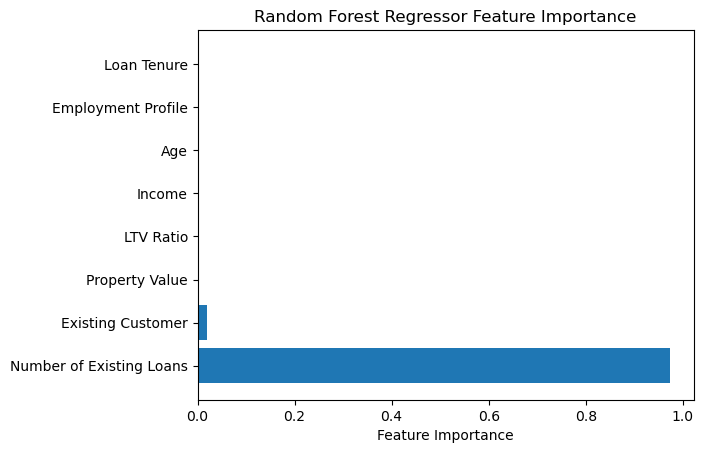

In [27]:
importances = model.feature_importances_

for feature_name, importance in zip(X_train.columns, importances):
    print(f"{feature_name}: {importance}")
    
sorted_idx = np.argsort(importances)[::-1]
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Regressor Feature Importance')
plt.show()

In [ ]:
# feature importances focus on existing customer and number of existing loan very very important to predict credit score

In [28]:
# #save Random Forest Regressor model

# with open('modelRFRegressor.pkl','wb') as file:
#     pickle.dump(model,file)